# **creating the cds and noncds mutation models**

In [115]:
import pysam 
from Bio import AlignIO
from tqdm import tqdm 
import json 
import matplotlib.pyplot as plt
import numpy as np 
from matplotlib.pyplot import figure

**getting the annotation file**

In [3]:
!cp /research/references/hsapiens/hg38/hg38.ncbiRefSeq.gtf.gz data/

In [11]:
!gunzip data/hg38.ncbiRefSeq.gtf.gz

In [12]:
%%bash 
(grep ^"#" data/hg38.ncbiRefSeq.gtf; grep -v ^"#" data/hg38.ncbiRefSeq.gtf | sort -k1,1 -k4,4n) | bgzip > data/hg38.ncbiRefSeq_sortedgff.bgz

In [13]:
!tabix -p gff data/hg38.ncbiRefSeq_sortedgff.bgz

In [32]:
!zcat data/hg38.ncbiRefSeq_sortedgff.bgz| cut -f 3 | sort | uniq -c 
#so this gff is of coding regions only 

 127169 3UTR
 247915 5UTR
1440848 CDS
1911608 exon
 118545 start_codon
 118439 stop_codon
 166923 transcript


**generating the fastas dictionary** 

In [37]:
list_chroms = ['chr' + str(i) for i in range(1, 23)]
fastas_dict = {}   # creating dictionary with fasta alignment, length of seq, 
for chrom in list_chroms:
    filename_tmp = "data/hg38_seq/{c}.fa".format(c=chrom)
    fastas_dict[chrom] = []
    fastas_dict[chrom].append(AlignIO.read(open(filename_tmp),"fasta"))
    alignment_tmp = fastas_dict[chrom][0]
    fastas_dict[chrom].append(len(str(alignment_tmp[0].seq)))

**reading in mutationfile**

In [2]:
mutations_lines = open("data/nature24018-s2/Aging_Oocytes_Supplementary_Table_DNMs_wrangled_unique.tsv").readlines()

## **making the cds and nonCds mutation dictionaries**

In [34]:
coding_muts = {}
noncoding_muts = {}
bases = ["A","T","G","C"]
for base1 in bases: 
    for base2 in bases: 
        for base3 in bases: 
            coding_muts[base1+base2+base3] = [0,{}]
            noncoding_muts[base1+base2+base3] = [0,{}]
            for base_changing in bases: 
                if base_changing != base2: 
                    coding_muts[base1+base2+base3][1][base1+base_changing+base3] = 0
                    noncoding_muts[base1+base2+base3][1][base1+base_changing+base3] = 0


In [71]:
list_fuck_ups = []
indels = []

for line in tqdm(mutations_lines[1:]): 
    chrom = line.split()[0]
    if chrom in list_chroms:
        site = int(line.split()[1])
        #print(site)

        alignment = fastas_dict[chrom][0]

        Ref_bp = line.split()[2].upper()
        New_bp = line.split()[3].upper()
        Ref_triplet= (str(alignment[0,site-2:site+1].seq)).upper() #tried and true values (the mutations file is 1-based so need to sub)
        New_triplet = (str(alignment[0,site-2])+str(New_bp)+str(alignment[0,site])).upper()

        if Ref_triplet == New_triplet: 
            #print(Ref_triplet +" "+New_triplet+" "+str(row_split_tmp[0])+"    "++"   "+(str(alignment[0,site[1]-2])+" "+Ref_bp+"   "+str(alignment[0,site[1]])+" "+New_bp)
            list_fuck_ups.append([Ref_triplet, New_triplet, line.split()])
        elif  len(Ref_triplet) == 3 and  len(New_triplet)==3 and "N" not in Ref_triplet: 
            #ok now time to add to dictionary 
            if not [record for record in pysam.Tabixfile(gff_filename).fetch(chrom, site, site+1)]: #both the gff and mutations file are 1-based
                noncoding_muts[Ref_triplet][0]+=1
                noncoding_muts[Ref_triplet][1][New_triplet] += 1 
            else: 
                coding_muts[Ref_triplet][0]+=1
                coding_muts[Ref_triplet][1][New_triplet] += 1 
 
        else: 
            assert len(New_bp) >= 1
            indels.append([Ref_triplet, New_triplet, line.split()]) # we dont want to include indels in our model anyways 

    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100437/100437 [41:30<00:00, 40.34it/s]


In [78]:
with open('MutDict_coding_2021_09_15.txt', 'w') as outfile:
    json.dump(coding_muts, outfile)

In [79]:
with open('MutDict_nonCoding_2021_09_15.txt', 'w') as outfile:
    json.dump(noncoding_muts, outfile)

In [87]:
sum_coding = 0
sum_noncoding = 0
for val in coding_muts.values(): 
    sum_coding+=val[0]
for val in noncoding_muts.values(): 
    sum_noncoding+=val[0]
print(sum_coding+ sum_noncoding+len(indels) - len(mutations_lines), "mutations excluded as they are in sex chromosomes")
print(sum_coding,"coding mutations")
print(sum_noncoding, "noncoding mutations")

61 mutations excluded as they are in sex chromosomes
56062 coding mutations
42504 noncoding mutations


# **ok make the model**

In [88]:
#importing the triplet coutns 
coding_trips = json.load(open("tripCount_cds_2021_09_15.txt"))
noncoding_trips = json.load(open("tripCount_nonCds_2021_09_15.txt"))

In [89]:
coding_model = {}
for key, item in coding_muts.items(): 
    n_muts = item[0]
    n_trips = coding_trips[key]
    mut = n_muts/n_trips
    
    into_dict = {}
    for into_trip_key,value in item[1].items(): 
        into_dict[into_trip_key] = value/n_muts
    
    coding_model[key] = [mut,into_dict]

In [93]:
noncoding_model = {}
for key, item in noncoding_muts.items(): 
    n_muts = item[0]
    n_trips = noncoding_trips[key]
    mut = n_muts/n_trips
    
    into_dict = {}
    for into_trip_key,value in item[1].items(): 
        into_dict[into_trip_key] = value/n_muts
    
    noncoding_model[key] = [mut,into_dict]

In [94]:
noncoding_model["AAA"], noncoding_muts["AAA"], noncoding_trips["AAA"]

([1.138046272048466e-05,
  {'ATA': 0.16874135546334718,
   'AGA': 0.5089903181189488,
   'ACA': 0.32226832641770403}],
 [723, {'ATA': 122, 'AGA': 368, 'ACA': 233}],
 63529930)

In [95]:
with open('Model_2021_09_15_coding.txt', 'w') as outfile:
    json.dump(coding_model, outfile)

In [96]:
with open('Model_2021_09_15_nonCoding.txt', 'w') as outfile:
    json.dump(noncoding_model, outfile)

# **analysing the models a bit**

In [98]:
coding_muts = []
noncoding_muts = []
for triplet,val in coding_model.items(): 
    coding_muts.append(val[0])
    noncoding_muts.append(noncoding_model[triplet][0])

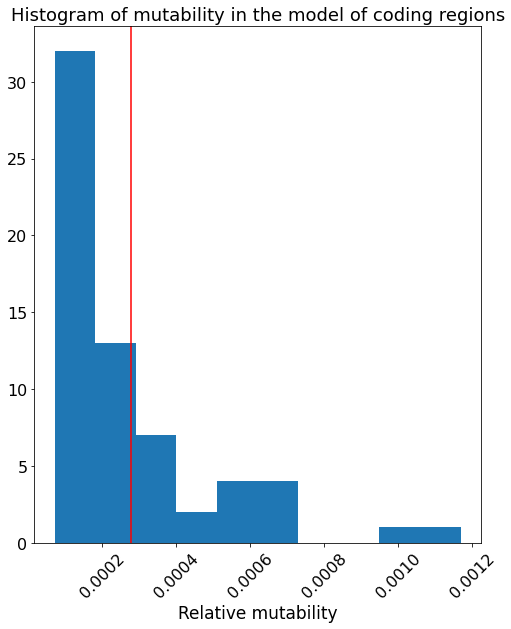

In [128]:
figure(figsize=(8, 9.5))#https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib
plt.hist(coding_muts)
plt.xlabel("Relative mutability", size=17)
plt.xticks(rotation=45, size = 16)
plt.yticks(size = 16)
plt.title("Histogram of mutability in the model of coding regions", size = 18)
plt.axvline(x=np.mean(coding_muts), color="red")
# plt.savefig("plots/mutabilityHistogram_codingModel_2021_09_15.png")

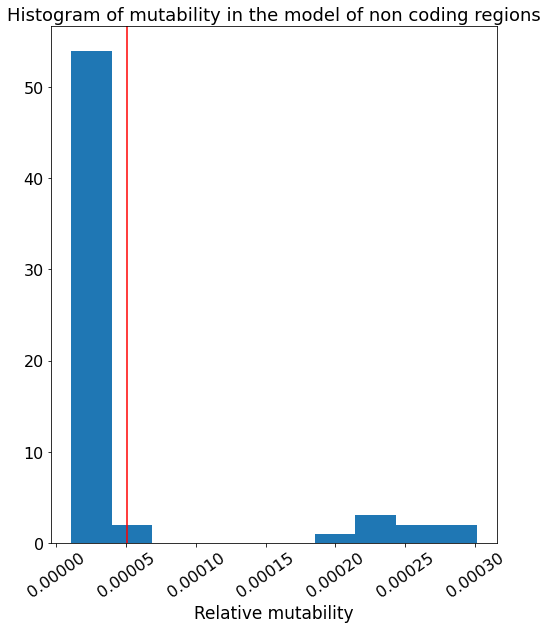

In [129]:
figure(figsize=(8, 9.5))#https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib
plt.hist(noncoding_muts)
plt.xlabel("Relative mutability", size=17)
plt.xticks(rotation=35, size = 16)
# plt.xticks( size = 16)
plt.yticks(size = 16)
plt.title("Histogram of mutability in the model of non coding regions", size = 18)
plt.axvline(x=np.mean(noncoding_muts), color="red")
# plt.savefig("plots/mutabilityHistogram_noncodingModel_2021_09_15.png")

In [105]:
"coding",np.mean(coding_muts),np.std(coding_muts)/np.sqrt(len(coding_muts))

('coding', 0.0002782743847789383, 2.7228065621718076e-05)

In [106]:
"noncoding",np.mean(noncoding_muts),np.std(noncoding_muts)/np.sqrt(len(noncoding_muts))

('noncoding', 5.0832407922549726e-05, 9.506530119018473e-06)

In [109]:
"coding is",np.mean(coding_muts)/np.mean(noncoding_muts),"the size of noncoding"

('coding is', 5.474349851829333, 'the size of noncoding')